## MNIST GAN PyTorch 

Geliştirme noktalarında parametreler değiştirip layerlar ekleyerek sonuç iyileştirme yapmaya çalıştım.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [90]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [91]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


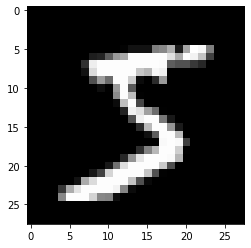

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

# Geliştirme 1 

In [93]:
from torch.utils.data import DataLoader

batch_size = 120
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([120, 1, 28, 28])
tensor([8, 5, 1, 3, 5, 9, 3, 5, 6, 3, 5, 0, 1, 2, 8, 7, 7, 2, 7, 2, 0, 2, 1, 8,
        5, 3, 7, 4, 9, 6, 5, 2, 2, 7, 4, 0, 9, 6, 7, 5, 1, 9, 5, 6, 2, 9, 6, 0,
        3, 3, 1, 2, 3, 0, 5, 1, 4, 0, 6, 6, 4, 5, 8, 4, 2, 5, 6, 0, 5, 9, 0, 1,
        9, 0, 1, 4, 3, 3, 8, 9, 5, 9, 2, 1, 6, 5, 6, 0, 7, 6, 0, 9, 4, 8, 6, 8,
        1, 7, 3, 4, 7, 6, 2, 5, 0, 5, 7, 2, 9, 9, 2, 8, 8, 7, 4, 9, 3, 0, 3, 1])


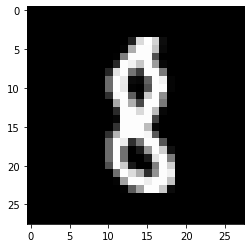

In [94]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [95]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [96]:
device

device(type='cpu')

In [97]:
image_size = 784
hidden_size = 256

# Geliştirme 2 

In [98]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [99]:
D.to(device);

# Geliştirme 3 

In [100]:
latent_size = 64

# Geliştirme 4 

In [101]:
G = nn.Sequential(
    nn.Linear(latent_size, 256),  
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),           
    nn.LeakyReLU(0.2),
    nn.Linear(512, 1024),         
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024),         
    nn.Linear(1024, image_size),   
    nn.Tanh()                     
)

In [102]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

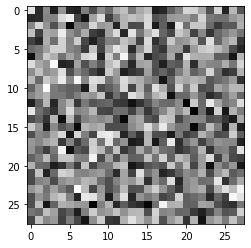

In [103]:
plt.imshow(gen_imgs[0], cmap='gray');

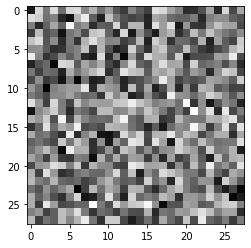

In [104]:
plt.imshow(gen_imgs[1], cmap='gray');

In [105]:
G.to(device);

# Geliştirme 5 

In [106]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)

In [107]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

# Geliştirme 6 

In [108]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [109]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [110]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

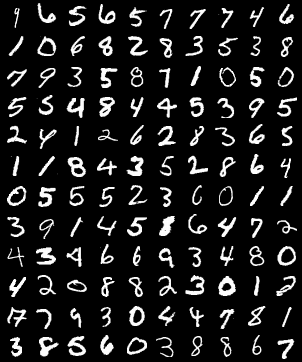

In [111]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


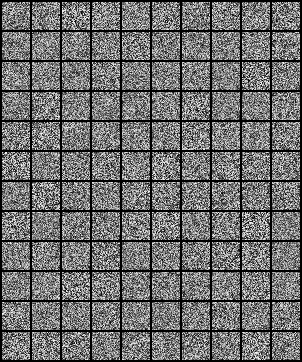

In [112]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [113]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/500], d_loss: 0.6173, g_loss: 1.3611, D(x): 0.86, D(G(z)): 0.35
Epoch [0/300], Step [400/500], d_loss: 0.8091, g_loss: 1.2810, D(x): 0.78, D(G(z)): 0.38
Saving fake_images-0001.png
Epoch [1/300], Step [200/500], d_loss: 1.0318, g_loss: 1.5968, D(x): 0.62, D(G(z)): 0.37
Epoch [1/300], Step [400/500], d_loss: 0.6115, g_loss: 2.8042, D(x): 0.84, D(G(z)): 0.27
Saving fake_images-0002.png
Epoch [2/300], Step [200/500], d_loss: 0.6045, g_loss: 2.4392, D(x): 0.77, D(G(z)): 0.25
Epoch [2/300], Step [400/500], d_loss: 0.3728, g_loss: 2.8624, D(x): 0.87, D(G(z)): 0.17
Saving fake_images-0003.png
Epoch [3/300], Step [200/500], d_loss: 0.4200, g_loss: 2.9488, D(x): 0.87, D(G(z)): 0.19
Epoch [3/300], Step [400/500], d_loss: 0.3566, g_loss: 3.4216, D(x): 0.88, D(G(z)): 0.16
Saving fake_images-0004.png
Epoch [4/300], Step [200/500], d_loss: 0.3588, g_loss: 3.2780, D(x): 0.90, D(G(z)): 0.19
Epoch [4/300], Step [400/500], d_loss: 0.2871, g_loss: 4.3892, D(x): 0.88, D(G(z)): 0.1

Saving fake_images-0040.png
Epoch [40/300], Step [200/500], d_loss: 0.3284, g_loss: 4.7362, D(x): 0.92, D(G(z)): 0.13
Epoch [40/300], Step [400/500], d_loss: 0.4513, g_loss: 4.4537, D(x): 0.92, D(G(z)): 0.23
Saving fake_images-0041.png
Epoch [41/300], Step [200/500], d_loss: 0.3255, g_loss: 2.7873, D(x): 0.95, D(G(z)): 0.18
Epoch [41/300], Step [400/500], d_loss: 0.1787, g_loss: 4.5961, D(x): 0.92, D(G(z)): 0.06
Saving fake_images-0042.png
Epoch [42/300], Step [200/500], d_loss: 0.2378, g_loss: 5.6501, D(x): 0.94, D(G(z)): 0.11
Epoch [42/300], Step [400/500], d_loss: 0.3178, g_loss: 7.6387, D(x): 0.92, D(G(z)): 0.10
Saving fake_images-0043.png
Epoch [43/300], Step [200/500], d_loss: 0.4288, g_loss: 5.3041, D(x): 0.84, D(G(z)): 0.09
Epoch [43/300], Step [400/500], d_loss: 0.5256, g_loss: 4.1774, D(x): 0.85, D(G(z)): 0.16
Saving fake_images-0044.png
Epoch [44/300], Step [200/500], d_loss: 0.3060, g_loss: 4.5526, D(x): 0.91, D(G(z)): 0.11
Epoch [44/300], Step [400/500], d_loss: 0.4215, g_

Epoch [79/300], Step [400/500], d_loss: 0.5775, g_loss: 1.7680, D(x): 0.86, D(G(z)): 0.27
Saving fake_images-0080.png
Epoch [80/300], Step [200/500], d_loss: 0.6701, g_loss: 2.7545, D(x): 0.76, D(G(z)): 0.19
Epoch [80/300], Step [400/500], d_loss: 0.8379, g_loss: 2.8970, D(x): 0.76, D(G(z)): 0.24
Saving fake_images-0081.png
Epoch [81/300], Step [200/500], d_loss: 0.6647, g_loss: 2.0704, D(x): 0.79, D(G(z)): 0.20
Epoch [81/300], Step [400/500], d_loss: 0.6467, g_loss: 2.3733, D(x): 0.79, D(G(z)): 0.22
Saving fake_images-0082.png
Epoch [82/300], Step [200/500], d_loss: 0.6703, g_loss: 2.2211, D(x): 0.83, D(G(z)): 0.26
Epoch [82/300], Step [400/500], d_loss: 0.7065, g_loss: 1.6774, D(x): 0.81, D(G(z)): 0.26
Saving fake_images-0083.png
Epoch [83/300], Step [200/500], d_loss: 0.6457, g_loss: 1.9525, D(x): 0.82, D(G(z)): 0.26
Epoch [83/300], Step [400/500], d_loss: 0.7366, g_loss: 3.0399, D(x): 0.78, D(G(z)): 0.24
Saving fake_images-0084.png
Epoch [84/300], Step [200/500], d_loss: 0.7700, g_

Saving fake_images-0119.png
Epoch [119/300], Step [200/500], d_loss: 0.7449, g_loss: 1.6288, D(x): 0.80, D(G(z)): 0.30
Epoch [119/300], Step [400/500], d_loss: 0.7747, g_loss: 1.7901, D(x): 0.70, D(G(z)): 0.24
Saving fake_images-0120.png
Epoch [120/300], Step [200/500], d_loss: 0.9345, g_loss: 1.8453, D(x): 0.70, D(G(z)): 0.29
Epoch [120/300], Step [400/500], d_loss: 0.8965, g_loss: 1.4217, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0121.png
Epoch [121/300], Step [200/500], d_loss: 0.9541, g_loss: 1.3542, D(x): 0.74, D(G(z)): 0.38
Epoch [121/300], Step [400/500], d_loss: 0.8641, g_loss: 1.8447, D(x): 0.72, D(G(z)): 0.30
Saving fake_images-0122.png
Epoch [122/300], Step [200/500], d_loss: 0.8406, g_loss: 1.5709, D(x): 0.73, D(G(z)): 0.32
Epoch [122/300], Step [400/500], d_loss: 1.0383, g_loss: 1.3928, D(x): 0.64, D(G(z)): 0.27
Saving fake_images-0123.png
Epoch [123/300], Step [200/500], d_loss: 0.8271, g_loss: 1.7764, D(x): 0.77, D(G(z)): 0.33
Epoch [123/300], Step [400/500], d_loss: 

Epoch [158/300], Step [200/500], d_loss: 0.9853, g_loss: 1.2253, D(x): 0.66, D(G(z)): 0.34
Epoch [158/300], Step [400/500], d_loss: 1.1015, g_loss: 1.0748, D(x): 0.65, D(G(z)): 0.39
Saving fake_images-0159.png
Epoch [159/300], Step [200/500], d_loss: 1.1651, g_loss: 1.1798, D(x): 0.63, D(G(z)): 0.39
Epoch [159/300], Step [400/500], d_loss: 0.9752, g_loss: 1.4866, D(x): 0.64, D(G(z)): 0.30
Saving fake_images-0160.png
Epoch [160/300], Step [200/500], d_loss: 1.1041, g_loss: 1.3245, D(x): 0.61, D(G(z)): 0.34
Epoch [160/300], Step [400/500], d_loss: 1.0285, g_loss: 1.0581, D(x): 0.69, D(G(z)): 0.40
Saving fake_images-0161.png
Epoch [161/300], Step [200/500], d_loss: 1.0360, g_loss: 1.5066, D(x): 0.60, D(G(z)): 0.30
Epoch [161/300], Step [400/500], d_loss: 0.9446, g_loss: 1.4506, D(x): 0.68, D(G(z)): 0.33
Saving fake_images-0162.png
Epoch [162/300], Step [200/500], d_loss: 0.9501, g_loss: 1.4508, D(x): 0.66, D(G(z)): 0.32
Epoch [162/300], Step [400/500], d_loss: 1.1314, g_loss: 1.1720, D(x)

Epoch [197/300], Step [400/500], d_loss: 1.2230, g_loss: 1.0213, D(x): 0.60, D(G(z)): 0.41
Saving fake_images-0198.png
Epoch [198/300], Step [200/500], d_loss: 1.2159, g_loss: 1.1185, D(x): 0.58, D(G(z)): 0.41
Epoch [198/300], Step [400/500], d_loss: 1.0882, g_loss: 1.0698, D(x): 0.58, D(G(z)): 0.34
Saving fake_images-0199.png
Epoch [199/300], Step [200/500], d_loss: 1.1568, g_loss: 0.9319, D(x): 0.58, D(G(z)): 0.37
Epoch [199/300], Step [400/500], d_loss: 1.3040, g_loss: 0.9943, D(x): 0.58, D(G(z)): 0.44
Saving fake_images-0200.png
Epoch [200/300], Step [200/500], d_loss: 1.3518, g_loss: 1.0389, D(x): 0.58, D(G(z)): 0.45
Epoch [200/300], Step [400/500], d_loss: 1.1688, g_loss: 1.1322, D(x): 0.59, D(G(z)): 0.38
Saving fake_images-0201.png
Epoch [201/300], Step [200/500], d_loss: 1.1144, g_loss: 1.0537, D(x): 0.57, D(G(z)): 0.34
Epoch [201/300], Step [400/500], d_loss: 1.1890, g_loss: 1.2251, D(x): 0.55, D(G(z)): 0.37
Saving fake_images-0202.png
Epoch [202/300], Step [200/500], d_loss: 

Saving fake_images-0237.png
Epoch [237/300], Step [200/500], d_loss: 1.3058, g_loss: 0.9629, D(x): 0.57, D(G(z)): 0.45
Epoch [237/300], Step [400/500], d_loss: 1.2850, g_loss: 0.9576, D(x): 0.53, D(G(z)): 0.40
Saving fake_images-0238.png
Epoch [238/300], Step [200/500], d_loss: 1.1470, g_loss: 0.9798, D(x): 0.57, D(G(z)): 0.37
Epoch [238/300], Step [400/500], d_loss: 1.1635, g_loss: 1.0980, D(x): 0.57, D(G(z)): 0.39
Saving fake_images-0239.png
Epoch [239/300], Step [200/500], d_loss: 1.1171, g_loss: 1.0495, D(x): 0.61, D(G(z)): 0.38
Epoch [239/300], Step [400/500], d_loss: 1.1740, g_loss: 1.0619, D(x): 0.55, D(G(z)): 0.36
Saving fake_images-0240.png
Epoch [240/300], Step [200/500], d_loss: 1.1990, g_loss: 1.0134, D(x): 0.62, D(G(z)): 0.45
Epoch [240/300], Step [400/500], d_loss: 1.2524, g_loss: 0.9104, D(x): 0.62, D(G(z)): 0.47
Saving fake_images-0241.png
Epoch [241/300], Step [200/500], d_loss: 1.1863, g_loss: 0.9627, D(x): 0.56, D(G(z)): 0.38
Epoch [241/300], Step [400/500], d_loss: 

Epoch [276/300], Step [200/500], d_loss: 1.2436, g_loss: 0.8328, D(x): 0.61, D(G(z)): 0.46
Epoch [276/300], Step [400/500], d_loss: 1.2176, g_loss: 1.0556, D(x): 0.59, D(G(z)): 0.44
Saving fake_images-0277.png
Epoch [277/300], Step [200/500], d_loss: 1.4159, g_loss: 0.9462, D(x): 0.48, D(G(z)): 0.44
Epoch [277/300], Step [400/500], d_loss: 1.3110, g_loss: 1.0505, D(x): 0.55, D(G(z)): 0.45
Saving fake_images-0278.png
Epoch [278/300], Step [200/500], d_loss: 1.2301, g_loss: 0.9660, D(x): 0.56, D(G(z)): 0.43
Epoch [278/300], Step [400/500], d_loss: 1.2008, g_loss: 1.0023, D(x): 0.60, D(G(z)): 0.43
Saving fake_images-0279.png
Epoch [279/300], Step [200/500], d_loss: 1.3294, g_loss: 0.9348, D(x): 0.59, D(G(z)): 0.48
Epoch [279/300], Step [400/500], d_loss: 1.2601, g_loss: 1.0095, D(x): 0.57, D(G(z)): 0.44
Saving fake_images-0280.png
Epoch [280/300], Step [200/500], d_loss: 1.1224, g_loss: 0.9470, D(x): 0.69, D(G(z)): 0.48
Epoch [280/300], Step [400/500], d_loss: 1.3578, g_loss: 0.9590, D(x)

In [114]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

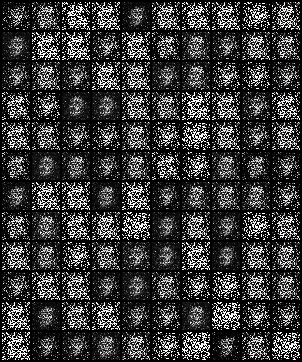

In [115]:
Image('./samples/fake_images-0001.png')

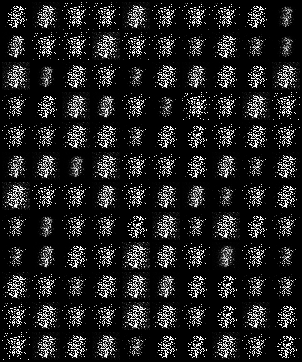

In [116]:
Image('./samples/fake_images-0005.png')

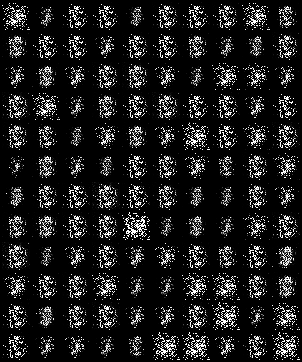

In [117]:
Image('./samples/fake_images-0010.png')

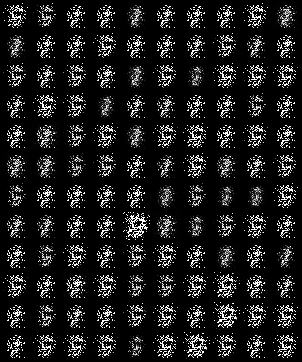

In [118]:
Image('./samples/fake_images-0015.png')

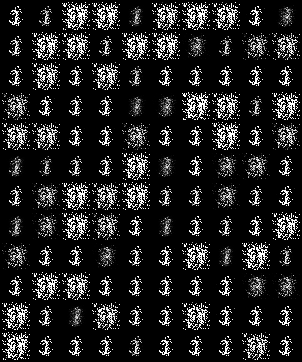

In [119]:
Image('./samples/fake_images-0020.png')

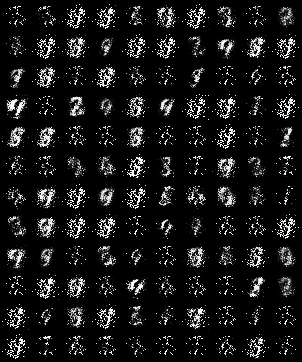

In [123]:
Image('./samples/fake_images-0050.png')

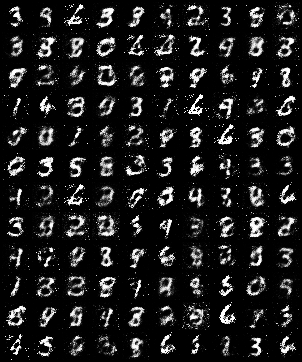

In [124]:
Image('./samples/fake_images-0100.png')

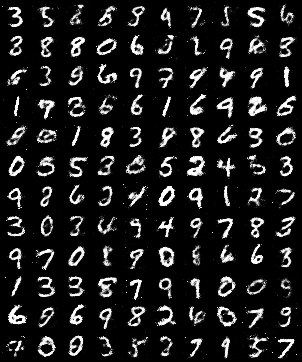

In [125]:
Image('./samples/fake_images-0200.png')

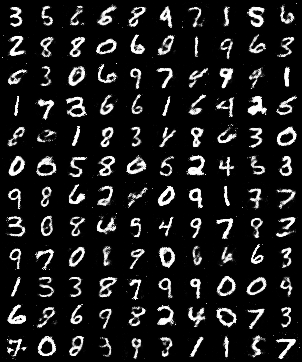

In [126]:
Image('./samples/fake_images-0300.png')

In [127]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

C:\Users\Beyza\H3M\gans_training.avi

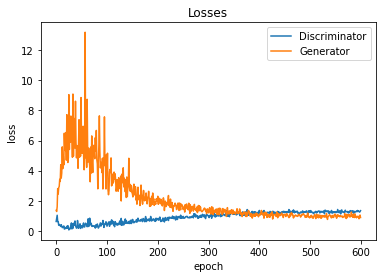

In [128]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

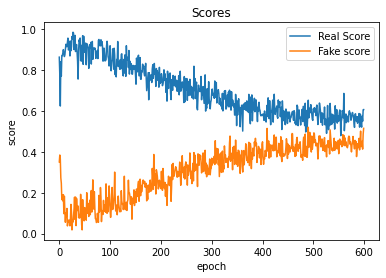

In [122]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');